1. Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного спуска и стохастического градиентного спуска. Построить графики среднеквадратичной ошибки от числа итераций для обоих методов на одном рисунке, сделать выводы о разнице скорости сходимости каждого из методов.

In [1]:
from sklearn.datasets import make_regression

%load_ext autoreload
%autoreload 2

from resource import *
%matplotlib inline

In [2]:
X_train, y_train, coef = make_regression(n_samples=1000,
                                         n_features=2,
                                         n_informative=2,
                                         n_targets=1,
                                         noise=5,
                                         coef=True,
                                         random_state=42)
# data_train = pd.DataFrame({'X': X_train[:, 0], 'Y': y_train})
data_train = pd.DataFrame({'X1': X_train[:, 0], 'X2': X_train[:, 1], 'Y': y_train})
X = data_train.drop('Y', axis=1)
Y = data_train['Y']

In [3]:
coef

array([40.71064891,  6.60098441])

In [4]:
np.linalg.inv(X.T @ X) @ X.T @ Y

0    40.890188
1     6.700321
dtype: float64

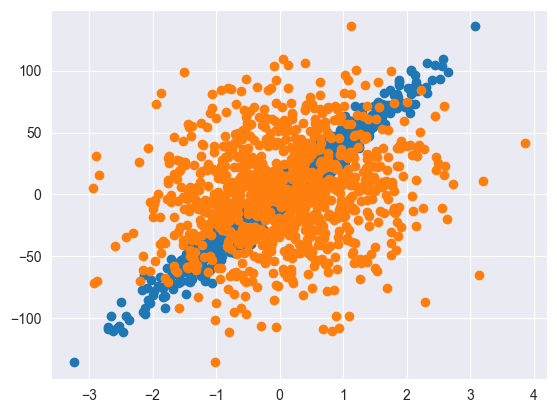

In [5]:
# посмотрим, что получилось

plt.plot(X_train, y_train, 'o')
plt.show()

In [6]:
from sklearn.linear_model import SGDRegressor

skl_regressor = SGDRegressor(max_iter=int(1e6), tol=1e-5, eta0=1e-3)
skl_l = skl_regressor.fit(X, Y)
skl_predictions = skl_regressor.predict(X)

print(skl_regressor.coef_, skl_regressor.intercept_)

[40.87810474  6.69862913] [0.00959166]


## Pseudocode
[Математические методы распознавания образов (курс лекций, В.В.Китов)](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BC%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%92.%D0%92.%D0%9A%D0%B8%D1%82%D0%BE%D0%B2%29)

```{python}
1. function gd(X, alpha, epsilon):
2. initialise beta
3. do:
4.  Beta = new_beta
5.  new_Beta = Beta - alpha*grad(X, beta)
6. until dist(new_beta, beta) < epsilon
7. return beta
```

## Stochastic gradient descent

```{python}
1. function sgd(X, alpha, epsilon):
2. initialise beta
3. do:
4.  X = shuffle(X)
5.  for x in X:
6.      Beta = new_beta
7.      new_Beta = Beta - alpha*grad(x, beta)
8. until dist(new_beta, beta) < epsilon
9. return beta
```

In [7]:
%%time
regressor = MyGradientLinearRegression(samples=X, targets=Y, alpha=1e-2, diff_mse=1e-5, print_cost=True)
l = regressor.fit()
w = regressor.get_weights()
w

Cost at iteration 100 is 61.46779010933987, weight=[34.60994105  5.87206617  0.56618725]
Cost at iteration 200 is 25.12084463043764, weight=[39.9122381   6.59259392  0.15555066]
Cost at iteration 300 is 24.23602212048216, weight=[4.07371015e+01 6.68497515e+00 3.86497866e-02]
Cost at iteration 400 is 24.214152387891794, weight=[4.08659493e+01 6.69767475e+00 1.36639610e-02]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 421 ...
CPU times: total: 328 ms
Wall time: 334 ms


array([4.08736665e+01, 6.69839482e+00, 1.19143516e-02])

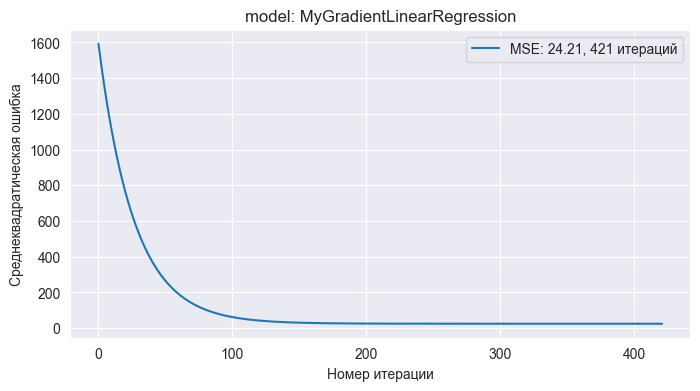

In [8]:
plot_learning_curves(model=regressor)

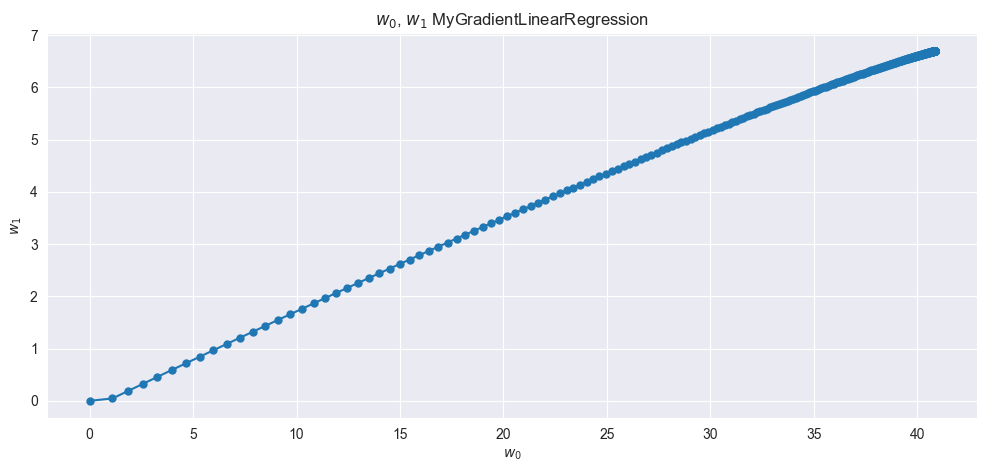

In [9]:
plot_weight_curves(regressor)

In [10]:
class MySGDLinearRegression(MyGradientLinearRegression):

    def _calc_gradient(self):
        n, k = self.samples.shape
        ind = np.random.randint(n)

        pred = self.samples[ind].reshape(-1, k) @ self.weight
        grad = 2 * (pred - self.targets[ind]) @ self.samples[ind].reshape(-1, k)

        return grad

In [11]:
%%time
sgd_regressor = MySGDLinearRegression(samples=X, targets=Y, alpha=1e-2, diff_mse=1e-5, print_cost=True)
sgd_l = sgd_regressor.fit()
sgd_w = sgd_regressor.get_weights()
sgd_w

Cost at iteration 100 is 121.15974642320478, weight=[30.73805872  6.01097277 -0.72058687]
Cost at iteration 200 is 25.17140858300186, weight=[39.99412642  7.10094975  0.24460549]
Model alpha: 0.01, diff_mse: 1e-05, iterations: 273 ...
CPU times: total: 172 ms
Wall time: 154 ms


array([41.65022566,  6.02033603,  1.67807526])

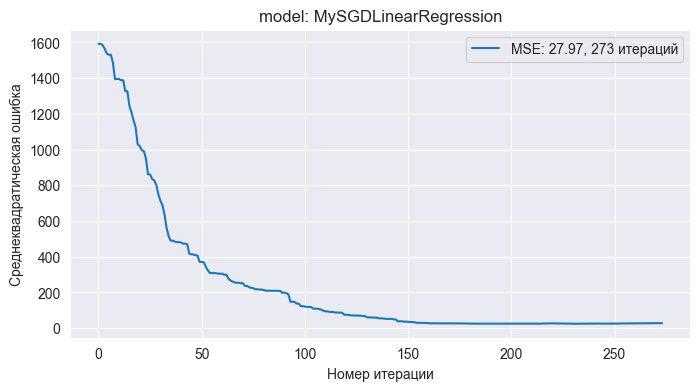

In [12]:
plot_learning_curves(model=sgd_regressor)

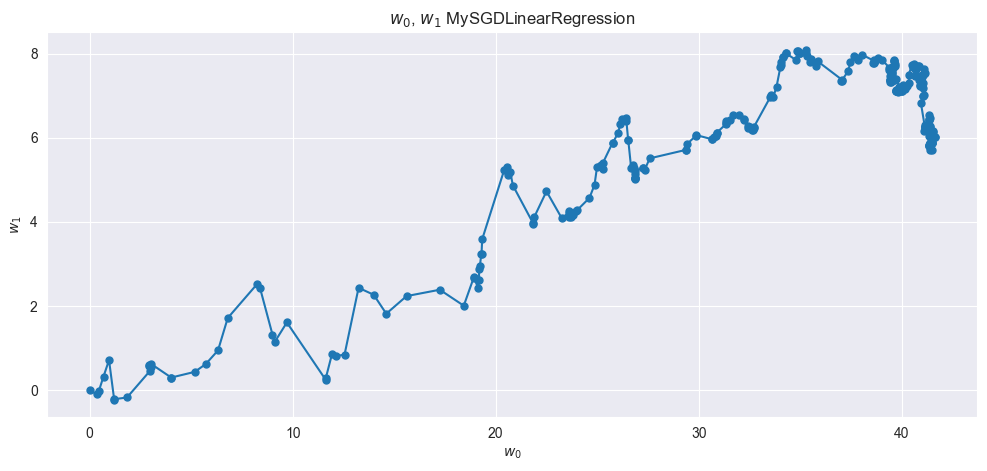

In [13]:
plot_weight_curves(sgd_regressor)

In [14]:
class MyMiniBatchLinearRegression(MyGradientLinearRegression):
    def __init__(self, batch_size=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.batch_size = batch_size

    def _calc_gradient(self):
        n, k = self.samples.shape
        n_batches = n // self.batch_size
        if n % self.batch_size != 0:
            n_batches += 1

        gradient = np.zeros(k)

        for b in range(n_batches):
            start = b * self.batch_size
            end = (b + 1) * self.batch_size
            X_batch = self.samples[start:end]
            y_batch = self.targets[start:end]

            # Compute gradient for the batch
            pred = X_batch @ self.weight
            grad = 2 * (pred - y_batch) @ X_batch
            gradient += grad

        return gradient / n_batches


In [15]:
%%time
mini_bach_regressor = MyMiniBatchLinearRegression(samples=X, targets=Y,
                                                  alpha=1e-2, diff_mse=1e-5,
                                                  batch_size=32,
                                                  print_cost=True)
mini_bach_l = mini_bach_regressor.fit()
mini_bach_w = mini_bach_regressor.get_weights()
mini_bach_w

Model alpha: 0.01, diff_mse: 1e-05, iterations: 12 ...
CPU times: total: 156 ms
Wall time: 156 ms


array([4.08884456e+01, 6.69973098e+00, 8.38121355e-03])

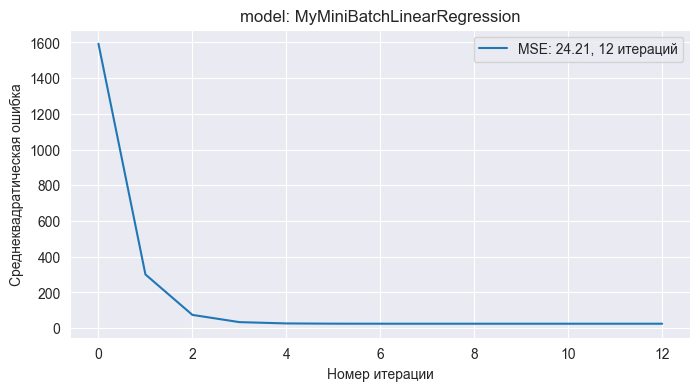

In [16]:
plot_learning_curves(model=mini_bach_regressor)

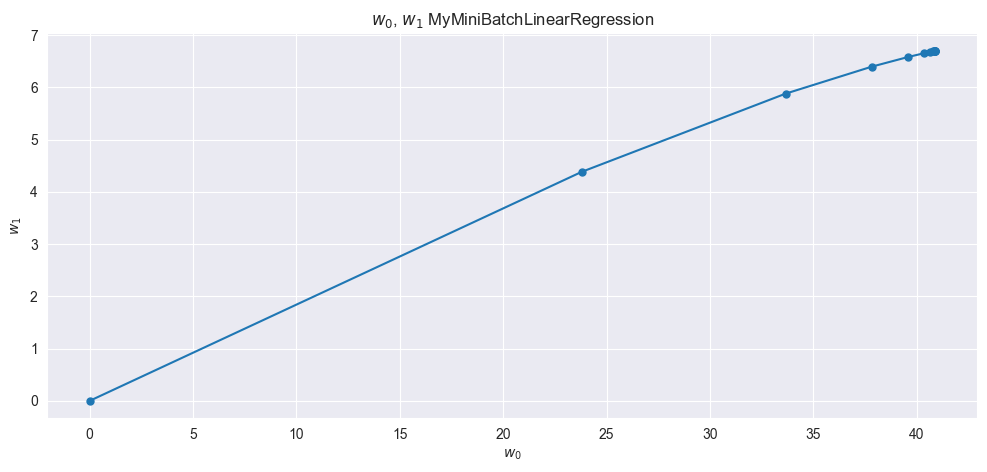

In [17]:
plot_weight_curves(mini_bach_regressor)

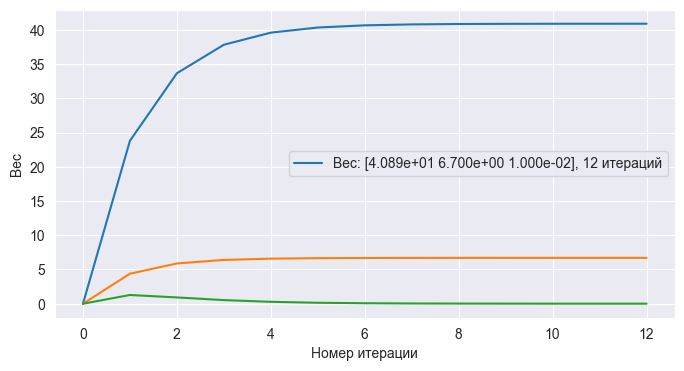

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 4)

learning_path = mini_bach_regressor.weight_dict
plt.plot(learning_path.keys(), learning_path.values())
ax.set_xlabel('Номер итерации')
ax.set_ylabel('Вес')
ax.legend(['Вес: {}, {} итераций'.format(np.round(list(learning_path.values())[-1], 2),
                                         list(learning_path.keys())[-1])])
plt.show()

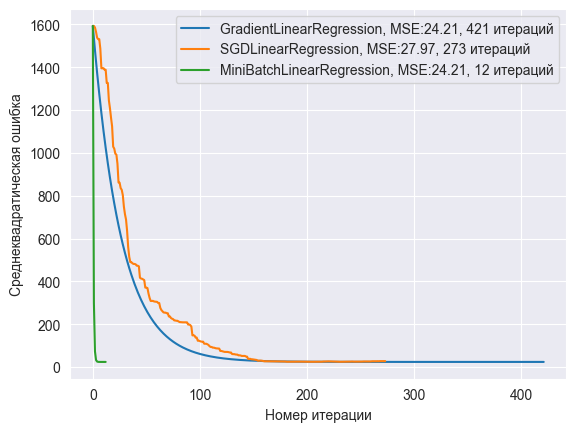

In [19]:
data = [(regressor, 'GradientLinearRegression'),
        (sgd_regressor, 'SGDLinearRegression'),
        (mini_bach_regressor, 'MiniBatchLinearRegression')
        ]

fig, ax = plt.subplots()

for model, label in data:
    learning_path = model.loss_dict
    ax.plot(learning_path.keys(), learning_path.values())

ax.set_xlabel('Номер итерации')
ax.set_ylabel('Среднеквадратическая ошибка')
ax.legend([f'{label}, MSE:{str(round(list(model.loss_dict.values())[-1], ndigits=2))}, {list(model.loss_dict.keys())[-1]} итераций'
           for model, label in data])

plt.show()


MSE на всех графиках стремится к 600 - это может означать, что модели достигли определенного предела в точности предсказаний. Возможно, дальнейшее улучшение точности будет требовать значительно больше данных или изменения модели.

Разница в количестве итераций между GradientLinearRegression, SGDLinearRegression, которая практически одинакова, может указывать на то, что обе модели сходятся к оптимальным весам схожим образом. SGDLinearRegression сходится быстрее, так как использует стохастический градиентный спуск.

У MiniBatchLinearRegression итераций на порядок меньше, потому что она использует мини-пакетный градиентный спуск, который обновляет веса после каждого прохода по пакету данных (мини-батчу). Это позволяет алгоритму быстрее сходиться к оптимальным значениям весов, особенно при работе с большим объемом данных.

**Преимущества**:
+ частота обновления модели выше, чем при пакетном градиентном спуске, но ниже чем в стохастическом градиентном спуске. Следовательно, этот вариант допускает более надежное схождение;
+ этот метод является вычислительно намного эффективнее, чем пакетный градиентный спуск или стохастический градиентный спуск, поскольку требуется меньше вычислений и ресурсов;

**Среди его недостатков**: использование этого варианта градиентного спуска вводит новый гиперпараметр, который необходимо отрегулировать - размер пакета (число наблюдений в мини-пакете).


2. [*] Добавить в алгоритм градиентного спуска L1 регуляризацию. Сравнить влияние коэффициентов регуляризации L1 и L2 на величину весов для примера из урока (лучше графически).